## Chapter 8: Model Selection and hyperparameter tuning

Python and sklearn version used for this notebook

In [1]:
import sys

# Print the version of Python
print(sys.version)

3.11.3 | packaged by Anaconda, Inc. | (main, Apr 19 2023, 23:46:34) [MSC v.1916 64 bit (AMD64)]


In [2]:
import sklearn

# Print the version of scikit-learn
sklearn_version = sklearn.__version__
sklearn_version


'1.2.2'

In [3]:
assert sys.version_info >= (3, 11) 

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.2.2")

In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Loading the sheep dataset

In [5]:
import pandas as pd

# Reading the dataset using our custom function
df = pd.read_csv("sheep_data.csv")

# Take a look at the first 5 rows of the dataset
df.head()

,x_mean,x_std_dev,x_variance,x_icv,x_median,x_minimum,x_maximum,x_skewness,x_kurtosis,x_iqr,...,z_max_psd,z_spectral_entropy,z_peak_frequency,z_spectral_centroid,z_spectral_spread,z_spectral_skewness,z_spectral_kurtosis,z_spectral_flatness,z_spectral_rolloff,label
0,-0.127047,0.051875,0.002691,-2.449076,-0.1260,-0.256,0.008,-0.145693,0.097937,0.06675,...,2.419580,0.593014,4.1250,3.052060,1.484061,-0.534922,2.346818,0.582179,4.5000,grazing
1,-0.115156,0.045295,0.002052,-2.542368,-0.1190,-0.256,0.008,-0.157547,0.796587,0.06375,...,2.495610,0.697870,4.1250,2.841880,1.531736,-0.376181,2.095706,0.543022,4.3125,grazing
2,-0.110078,0.038005,0.001444,-2.896433,-0.1165,-0.171,0.008,0.588613,0.043011,0.06225,...,2.683044,0.836558,0.1875,2.586789,1.709652,-0.202790,1.673985,0.481731,4.3125,grazing
3,-0.111156,0.039253,0.001541,-2.831817,-0.1155,-0.175,0.008,0.485738,-0.082020,0.06275,...,2.883204,0.649190,0.1875,2.357693,1.773804,0.028470,1.512067,0.379781,4.3125,grazing
4,-0.108047,0.041168,0.001695,-2.624508,-0.1110,-0.175,0.008,0.385131,-0.410892,0.06225,...,3.376866,0.657325,0.1875,2.062371,1.770855,0.393420,1.640347,0.488464,4.3125,grazing


In [6]:
print("Shape:", df.shape)
print("NaN Values:", df.isnull().sum().sum(), "\n")

Shape: (64626, 83)
NaN Values: 0 



In [7]:
print(df.describe())

             x_mean     x_std_dev    x_variance         x_icv      x_median  \
count  64626.000000  64626.000000  6.462600e+04  64626.000000  64626.000000   
mean       0.216214      0.052556  1.014582e-02     53.730916      0.215428   
std        0.378714      0.085929  4.301334e-02    109.136817      0.379740   
min       -0.984359      0.000614  3.770000e-07   -338.293519     -0.989000   
25%       -0.074238      0.003238  1.050000e-05     -1.302709     -0.077500   
50%        0.336883      0.009609  9.230000e-05      8.853306      0.336000   
75%        0.483746      0.075182  5.652357e-03     91.993652      0.483000   
max        0.917594      1.157193  1.339095e+00   1137.662090      0.975500   

          x_minimum     x_maximum    x_skewness    x_kurtosis         x_iqr  \
count  64626.000000  64626.000000  64626.000000  64626.000000  64626.000000   
mean       0.097655      0.342900     -0.057744      1.088611      0.065558   
std        0.434949      0.422819      0.882009    

### Transorming class labels into integers

In [8]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, df.columns != 'label'].values
y = df['label'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
label_encoder.classes_

array(['grazing', 'resting', 'scratching', 'standing', 'walking'],
      dtype=object)

### Split the dataset 

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, stratify = y, random_state = 1)

### Cross Validation

In [22]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import numpy as np
from tqdm import tqdm

# Define the models (excluding LightGBM)
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "SVM Radial": SVC(kernel='rbf', random_state=42),
    "MLP": MLPClassifier(random_state=42)
}

# Define the Stratified K-Fold Cross-Validator
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform K-Fold CV and store the results
model_scores = {}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=stratified_kfold, n_jobs=-1)
    model_scores[name] = np.mean(scores)
    print(f"{name}: Average Accuracy = {np.mean(scores):.4f}")

# Selecting the best model based on the highest average accuracy
best_model = max(model_scores, key=model_scores.get)
print(f"\nBest Model: {best_model} with Average Accuracy = {model_scores[best_model]:.4f}")

Random Forest: Average Accuracy = 0.9878
LightGBM: Average Accuracy = 0.9891
Decision Tree: Average Accuracy = 0.9663
XGBoost: Average Accuracy = 0.9918
SVM Radial: Average Accuracy = 0.7568
MLP: Average Accuracy = 0.8979

Best Model: XGBoost with Average Accuracy = 0.9918


In [28]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
Best Score: 0.9902958046871252


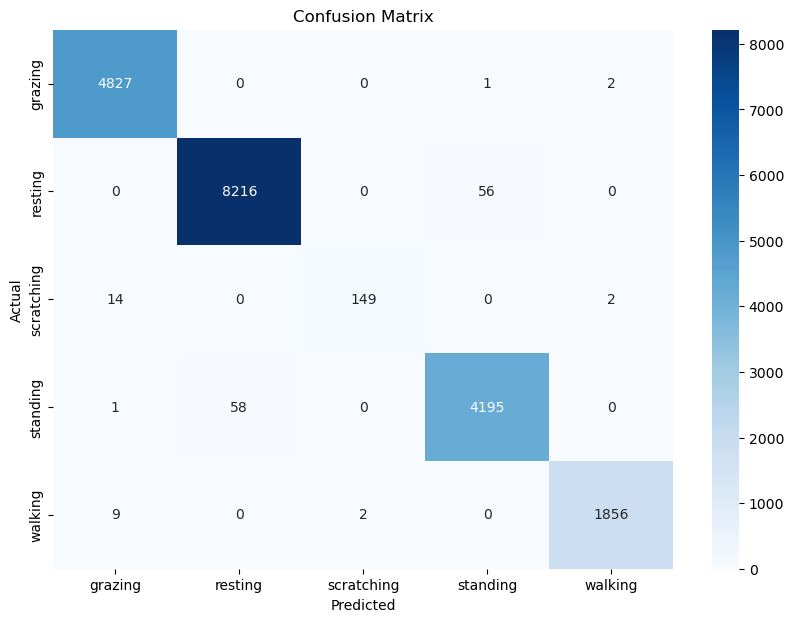

Classification Report:
               precision    recall  f1-score   support

     grazing       1.00      1.00      1.00      4830
     resting       0.99      0.99      0.99      8272
  scratching       0.99      0.90      0.94       165
    standing       0.99      0.99      0.99      4254
     walking       1.00      0.99      1.00      1867

    accuracy                           0.99     19388
   macro avg       0.99      0.98      0.98     19388
weighted avg       0.99      0.99      0.99     19388



In [33]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Best model from Grid Search
best_model = grid_search.best_estimator_

best_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = best_model.predict(X_test)

# Generate the classification report
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix with class names
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('cm.png', dpi=300)
plt.show()

# Display the results
print("Classification Report:\n", class_report)


In [37]:
# RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint

# Define the parameter distribution
param_dist = {
    'n_estimators': sp_randint(100, 500),
    'max_depth': sp_randint(3, 10), 
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, 
                                   n_iter=100, cv=5, random_state=42, n_jobs=-1)

# Fit to the data
random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


Best Parameters: {'max_depth': 9, 'max_features': 'auto', 'n_estimators': 370}
Best Score: 0.9508820574195646


In [39]:
# HalvingGridSearchCV

from sklearn.experimental import enable_halving_search_cv  # Explicitly require this experimental feature
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


# Define the model and parameter space
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15]
}

# Initialize and run the Halving Grid Search
halving_grid_search = HalvingGridSearchCV(model, param_grid, cv=5, factor=2, random_state=42)
halving_grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", halving_grid_search.best_params_)
print("Best Score:", halving_grid_search.best_score_)

# Evaluate on the test set
best_model = halving_grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print(f"Test Set Accuracy: {test_accuracy:.4f}")


Best Parameters: {'max_depth': 15, 'n_estimators': 300}
Best Score: 0.9768948804996072
Test Set Accuracy: 0.9802
